<a href="https://colab.research.google.com/github/matan034/Knee-Bone-Segmentation/blob/main/KneeProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocess



In [ ]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive

In [ ]:
 #CONSTANTS!!!

# STEP 1 - Load and visualize data


SLICE_X = True
SLICE_Y = False
SLICE_Z = True
VALIDATION=True
TRAIN_AND_TEST=True
FIND_BOUNDARY=False
IS_BOUNDARY_PATH = False
REMOVE_BLACK_NO_BONE_IMAGES=False


drive.mount('/content/drive')
dataInputPath = '/content/drive/My Drive/KneeProject/volume_data'

if IS_BOUNDARY_PATH:
  trainingOutputPath = '/content/drive/My Drive/KneeProject/trainingBoundary/' #when creating boundary images go to path trainingBoundary regular images in training
  testingOutputPath = '/content/drive/My Drive/KneeProject/testingBoundary/'
  validationOutputPath = '/content/drive/My Drive/KneeProject/validationBoundary/'
else:
  trainingOutputPath = '/content/drive/My Drive/KneeProject/training/'
  testingOutputPath = '/content/drive/My Drive/KneeProject/testing/'
  validationOutputPath = '/content/drive/My Drive/KneeProject/validation/'

trainingImageSliceOutput = os.path.join(trainingOutputPath, 'img/femur')
trainingMaskSliceOutput = os.path.join(trainingOutputPath, 'mask/femur')

 #when creating boundary images go to path testingBoundary regular images in testing
testingImageSliceOutput = os.path.join(testingOutputPath, 'img/femur')
testingMaskSliceOutput = os.path.join(testingOutputPath, 'mask/femur')

 #when creating boundary images go to path validationBoundary regular images in validation
validationImageSliceOutput = os.path.join(validationOutputPath, 'img/femur')
validationMaskSliceOutput = os.path.join(validationOutputPath, 'mask/femur')

# STEP 2 - Image normalization
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN



SLICE_DECIMATE_IDENTIFIER = 3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Get all img and mask aths
imgPaths=[]
maskPaths=[]
for folderName in os.listdir(dataInputPath):
    imgPaths.append(os.path.join(dataInputPath, folderName + "/img/"))
    maskPaths.append(os.path.join(dataInputPath, folderName + "/mask/"))

**Read img/mask functions**




In [ ]:
import itertools
import shelve
from sklearn.model_selection import train_test_split
from skimage.segmentation import find_boundaries

# Normalize image
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img

# Save volume slice to file
def saveSlice(img, fname, path, only_boundary=False):
    if only_boundary:
      img = find_boundaries(img,mode='thick')
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')


def check_data_in_image(img, minAmountOfPixelsInImg=1):
    if not REMOVE_BLACK_NO_BONE_IMAGES:
        return True
    else:
        count = np.count_nonzero(img)
        if count > minAmountOfPixelsInImg:
            return True
        else:
            return False


#gets main folder name
def getFolderName(path, key = 'volume_data'):
        parts = path.split(os.path.sep)
        idx = parts.index('volume_data')
        folderName= parts[idx +1]
        return folderName



#reads normalizes and saves slices
def readAndProcessVolumes(img_tuple, mask_tuple):
    for img_idx,img_filename in enumerate(sorted(glob.iglob(img_tuple[0]+'*.nii'))):
        for mask_idx,mask_filename in enumerate(sorted(glob.iglob(mask_tuple[0]+'*.nii'))):
          img_folderName=getFolderName(img_tuple[0])
          mask_folderName=getFolderName(mask_tuple[0])
          img = readImageVolume(img_filename, img_tuple[3])
          mask = readImageVolume(mask_filename, mask_tuple[3])
          numOfSlices = sliceAndSaveVolumeImage(img_tuple=(img, img_folderName + str(img_idx),img_tuple[1],img_tuple[2]),
                                                mask_tuple=(mask, mask_folderName + str(mask_idx),mask_tuple[1],mask_tuple[2]))
          print(f'\n{img_filename + mask_filename}, {numOfSlices} slices created \n')
          return numOfSlices


#tuple - vol, fname, trainPath, testPath
def sliceAndSaveVolumeImage(img_tuple, mask_tuple):
    dims = {"img":img_tuple[0].shape, "mask": mask_tuple[0].shape}
    print(dims["img"], "image dims")
    print(dims["mask"], "mask dims")
    cnt = 0
    if SLICE_X:
        for i in range(dims["img"][0]):
            mask_slice = mask_tuple[0][i,:,:]
            MIN_PIXELS_IN_MASK=int(mask_slice.size*0.05)
            if check_data_in_image(mask_slice,MIN_PIXELS_IN_MASK):
              cnt += 1
              img_slice = img_tuple[0][i,:,:]
              if i % 5 == 0:
                  saveSlice(img_slice, img_tuple[1]+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', img_tuple[3])
                  saveSlice(mask_slice, mask_tuple[1]+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', mask_tuple[3], FIND_BOUNDARY)
              else:
                  saveSlice(img_slice, img_tuple[1]+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', img_tuple[2])
                  saveSlice(mask_slice, mask_tuple[1]+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', mask_tuple[2], FIND_BOUNDARY)

    if SLICE_Y:
        for i in range(dims["img"][1]):
            mask_slice = mask_tuple[0][:,i,:]
            MIN_PIXELS_IN_MASK=int(mask_slice.size*0.1)
            if check_data_in_image(mask_slice,MIN_PIXELS_IN_MASK):
              cnt += 1
              img_slice = img_tuple[0][:,i,:]
              if i % 5 == 0:
                  saveSlice(img_slice, img_tuple[1]+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', img_tuple[3])
                  saveSlice(mask_slice, mask_tuple[1]+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', mask_tuple[3],FIND_BOUNDARY)
              else:
                  saveSlice(img_slice, img_tuple[1]+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', img_tuple[2])
                  saveSlice(mask_slice, mask_tuple[1]+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', mask_tuple[2],FIND_BOUNDARY)
    if SLICE_Z:
        for i in range(dims["img"][2]):
            mask_slice = mask_tuple[0][:,:,i]
            MIN_PIXELS_IN_MASK=int(mask_slice.size*0.1)
            if check_data_in_image(mask_slice,MIN_PIXELS_IN_MASK):
              cnt += 1
              img_slice = img_tuple[0][:,:,i]
              if i % 5 == 0:
                  saveSlice(img_slice, img_tuple[1]+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', img_tuple[3])
                  saveSlice(mask_slice, mask_tuple[1]+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', mask_tuple[3],FIND_BOUNDARY)
              else:
                  saveSlice(img_slice, img_tuple[1]+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', img_tuple[2])
                  saveSlice(mask_slice, mask_tuple[1]+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', mask_tuple[2],FIND_BOUNDARY)
    return cnt


def clear_dir(path):
  if os.path.exists(path):
    for item in os.listdir(path):
      if not os.path.isdir(os.path.join(path, item)):
        os.remove(os.path.join(path, item))

**Save png of all slices**

In [ ]:
  clear_dir(trainingImageSliceOutput)
  clear_dir(testingImageSliceOutput)
  clear_dir(trainingMaskSliceOutput)
  clear_dir(testingMaskSliceOutput)
  clear_dir(validationImageSliceOutput)
  clear_dir(validationMaskSliceOutput)

In [ ]:
NUM_OF_FOLDERS=len(os.listdir(dataInputPath))-1
#NUM_OF_FOLDERS=1
if TRAIN_AND_TEST:
  for i in range(NUM_OF_FOLDERS):
    numOfSlicesImgs=readAndProcessVolumes((imgPaths[i],trainingImageSliceOutput,testingImageSliceOutput, True),
                                          (maskPaths[i],trainingMaskSliceOutput,testingMaskSliceOutput, False)) # read all img volumes and generate pngs from slices for Training and testing images

if VALIDATION:
    numOfSlicesImgs=readAndProcessVolumes((imgPaths[NUM_OF_FOLDERS],validationImageSliceOutput,validationImageSliceOutput, True),
                                        (maskPaths[NUM_OF_FOLDERS],validationMaskSliceOutput,validationMaskSliceOutput, False))

(512, 512, 570) image dims
(512, 512, 570) mask dims
[+] Slice saved: /content/drive/My Drive/KneeProject/training/mask/femur/ALMar0-slice569_z.png
/content/drive/My Drive/KneeProject/volume_data/ALMar/img/301 3D_VIEW_PD.nii/content/drive/My Drive/KneeProject/volume_data/ALMar/mask/Segmentation.ALMar-Femur-label.nii, 1082 slices created 

(512, 512, 570) image dims
(512, 512, 570) mask dims
[+] Slice saved: /content/drive/My Drive/KneeProject/training/mask/femur/FK0-slice569_z.png
/content/drive/My Drive/KneeProject/volume_data/FK/img/301 3D_VIEW_PD_1.nii/content/drive/My Drive/KneeProject/volume_data/FK/mask/Segmentation_FK-Femur-label.nii, 1082 slices created 

(512, 512, 570) image dims
(512, 512, 570) mask dims
[+] Slice saved: /content/drive/My Drive/KneeProject/training/mask/femur/BMS0-slice569_z.png
/content/drive/My Drive/KneeProject/volume_data/BMS/img/201 3D_VIEW_PD.nii/content/drive/My Drive/KneeProject/volume_data/BMS/mask/Segmentation_BMS-Femur-label.nii, 1082 slices creat

#Constants


In [ ]:
import os,glob
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import pickle


In [ ]:

SEED = 909
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 64
BATCH_SIZE_VALIDATION = 1

IMAGE_HEIGHT =  256
IMAGE_WIDTH = 256
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

drive.mount('/content/drive')

IS_BOUNDARY_PATH = False

if IS_BOUNDARY_PATH:
  data_dir_train_image = '/content/drive/My Drive/KneeProject/trainingBoundary/img/'  #when using boundary images go to path trainingBoundary regular images in training
  data_dir_train_mask = '/content/drive/My Drive/KneeProject/trainingBoundary/mask/'

  data_dir_test_image = '/content/drive/My Drive/KneeProject/testingBoundary/img/'  #when creating boundary images go to path testingBoundary regular images in testing
  data_dir_test_mask = '/content/drive/My Drive/KneeProject/testingBoundary/mask/'

  data_dir_val_image = '/content/drive/My Drive/KneeProject/validationBoundary/img/' #when creating boundary images go to path validationBoundary regular images in validation
  data_dir_val_mask = '/content/drive/My Drive/KneeProject/validationBoundary/mask/'
else:
   data_dir_train_image = '/content/drive/My Drive/KneeProject/training/img/'  #when using boundary images go to path trainingBoundary regular images in training
   data_dir_train_mask = '/content/drive/My Drive/KneeProject/training/mask/'

   data_dir_test_image = '/content/drive/My Drive/KneeProject/testing/img/'  #when creating boundary images go to path testingBoundary regular images in testing
   data_dir_test_mask = '/content/drive/My Drive/KneeProject/testing/mask/'

   data_dir_val_image = '/content/drive/My Drive/KneeProject/validation/img/' #when creating boundary images go to path validationBoundary regular images in validation
   data_dir_val_mask = '/content/drive/My Drive/KneeProject/validation/mask/'


NUM_TRAIN = len(os.listdir(data_dir_train_image+"femur"))
NUM_TEST = len(os.listdir(data_dir_test_image+"femur"))
NUM_VAL = len(os.listdir(data_dir_val_image+"femur"))

NUM_OF_EPOCHS = 100
LEARNING_RATE = 0.0001

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

LOSS_FUNC_DICE=True
LOSS_FUNC_TRAV=False
USE_IOU = True
TRANSFER_LEARNING = True
CLASSIFIER =False
EXTRA_LAYER = True
UNET_MODEL_TO_TRAIN="attention" # OPTIONS : "unet", "attention", "3plus"

Mounted at /content/drive


# Data prep

In [ ]:
print(len(os.listdir(data_dir_train_image+"/femur")),"trainig images")
print(len(os.listdir(data_dir_train_mask+"/femur")),"trainig mask")
print(len(os.listdir(data_dir_test_image+"/femur")),"test images")
print(len(os.listdir(data_dir_test_mask+"/femur")),"test mask")
print(len(os.listdir(data_dir_val_image+"/femur")),"validation images")

9314 trainig images
9314 trainig mask
2336 test images
2336 test mask
1052 validation images


In [ ]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255,
#                         featurewise_center=True,
#                      featurewise_std_normalization=True,
#                          rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    class_mode_selection = 'grayscale'
    if TRANSFER_LEARNING or CLASSIFIER:
      class_mode_selection = 'rgb'
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, color_mode=class_mode_selection,class_mode=None,  batch_size=BATCH_SIZE, seed=SEED) #color_mode='grayscale'
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, color_mode=class_mode_selection,class_mode=None, batch_size=BATCH_SIZE, seed=SEED) #color_mode='grayscale'

    return zip(img_generator, msk_generator)

# Remember not to perform any image augmentation in the test generator!
def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    class_mode_selection = 'grayscale'
    if TRANSFER_LEARNING or CLASSIFIER:
      class_mode_selection = 'rgb'
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, color_mode=class_mode_selection,class_mode=None,  batch_size=BATCH_SIZE, seed=SEED) #color_mode='grayscale'
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, color_mode=class_mode_selection,class_mode=None,  batch_size=BATCH_SIZE, seed=SEED) #color_mode='grayscale'

    return zip(img_generator, msk_generator)

def create_segmentation_generator_validation(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    class_mode_selection = 'grayscale'
    if TRANSFER_LEARNING or CLASSIFIER:
      class_mode_selection = 'rgb'
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, color_mode=class_mode_selection,class_mode=None,  batch_size=BATCH_SIZE, seed=SEED) #color_mode='grayscale'
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, color_mode=class_mode_selection,class_mode=None,  batch_size=BATCH_SIZE, seed=SEED) #color_mode='grayscale'
    return zip(img_generator, msk_generator)

In [ ]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)
validation_generator = create_segmentation_generator_validation(data_dir_val_image, data_dir_val_mask, BATCH_SIZE_VALIDATION)

Found 9314 images belonging to 1 classes.
Found 9314 images belonging to 1 classes.
Found 2336 images belonging to 1 classes.
Found 2336 images belonging to 1 classes.
Found 1052 images belonging to 1 classes.
Found 1052 images belonging to 1 classes.


In [ ]:

def display(display_list):
    plt.figure(figsize=(15,15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [ ]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

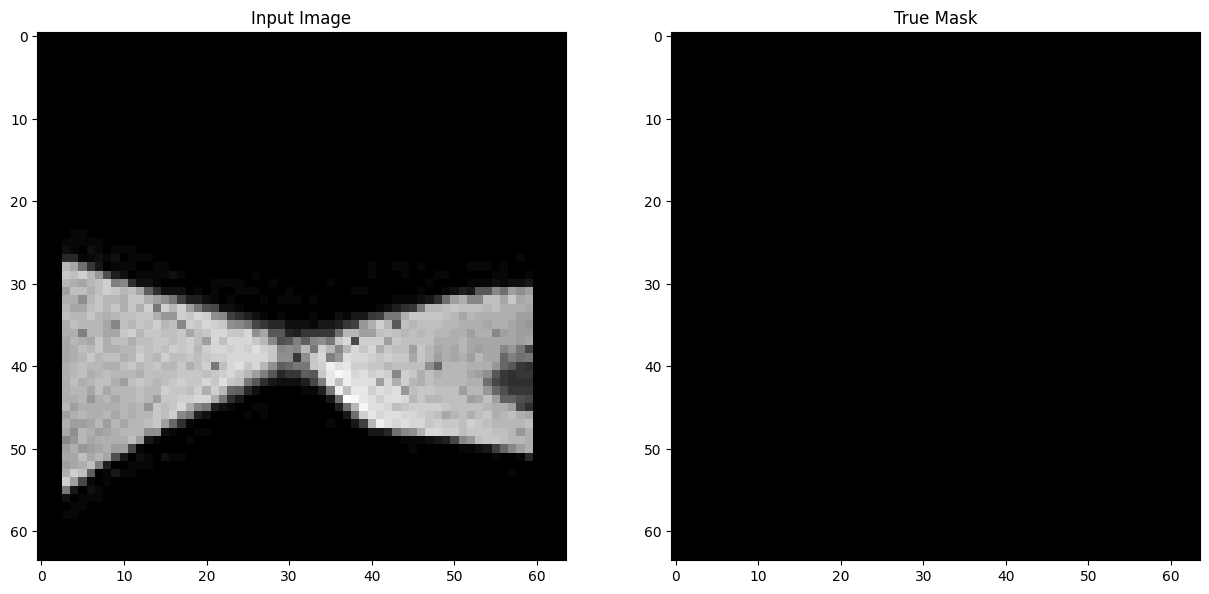

KeyboardInterrupt: ignored

In [ ]:
show_dataset(train_generator, 4)

# Unets
Base Unet




In [ ]:
#put refrence here
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs

    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')

    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * (2 ** level), **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)

    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * (2 ** level), strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)

    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)

    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [ ]:
from keras.applications import ResNet50,VGG16
#resnet50 = ResNet50(include_top=False, weights="imagenet", input_shape=(256,256,3))
#resnet50.summary()

vgg16 = VGG16(include_top=False, weights="imagenet", input_shape=(256,256,3))
vgg16.summary()



58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

Attention Unet

In [ ]:
#put refrence here
import keras.layers as layers
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D,GlobalAveragePooling2D
from keras.applications import ResNet50,VGG16

class attention_unet():
  def __init__(self,img_rows=512,img_cols=512,tl=False,classifier=False, extra_layer = False):
    self.img_rows=img_rows
    self.img_cols=img_cols
    if tl or classifier:
      self.img_shape=(self.img_rows,self.img_cols,3)
    else:
      self.img_shape=(self.img_rows,self.img_cols,1)
    self.df=64
    self.uf=64
    self.tl=tl
    self.classifier=classifier
    self.extra_layer = extra_layer

  def build_unet(self):
    def conv2d(layer_input,filters,dropout_rate=0,bn=False):
      d = conv1d(layer_input,filters,dropout_rate,bn)
      d = conv1d(d,filters,dropout_rate,bn)
      if dropout_rate:
        d=layers.Dropout(dropout_rate)(d)
      return d

    def conv1d(layer_input,filters,dropout_rate=0,bn=False):
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(layer_input)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)
      return d

    def deconv2d(layer_input,filters,bn=False):
      u=layers.UpSampling2D((2,2))(layer_input)
      u=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(u)
      if bn:
        u=layers.BatchNormalization()(u)
      u=layers.Activation('relu')(u)

      return u

    def attention_block(F_g,F_l,F_int,bn=False):
      g=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_g)
      if bn:
        g=layers.BatchNormalization()(g)
      x=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_l)
      if bn:
        x=layers.BatchNormalization()(x)
      psi=layers.Add()([g,x])
      psi=layers.Activation('relu')(psi)

      psi=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi)

      if bn:
        psi=layers.BatchNormalization()(psi)
      psi=layers.Activation('sigmoid')(psi)

      return layers.Multiply()([F_l,psi])

    inputs = layers.Input(shape=self.img_shape, name="input_1")
    if self.tl:
      resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
      conv1 = resnet50.get_layer("input_1").output
      conv2 = resnet50.get_layer("conv1_relu").output
      conv3 = resnet50.get_layer("conv2_block3_out").output
      conv4 = resnet50.get_layer("conv3_block4_out").output
      if self.extra_layer:
        conv5 = resnet50.get_layer("conv4_block6_out").output
        pool5=layers.MaxPooling2D((2,2))(conv5)
        mid_block=conv2d(pool5,self.df*16,dropout_rate=0.5,bn=True)
      else:
        mid_block=resnet50.get_layer("conv4_block6_out").output
    else:
      conv1=conv2d(inputs,self.df)
      pool1=layers.MaxPooling2D((2,2))(conv1)

      conv2=conv2d(pool1,self.df*2,bn=True)
      pool2=layers.MaxPooling2D((2,2))(conv2)
      conv3=conv2d(pool2,self.df*4,bn=True)
      pool3=layers.MaxPooling2D((2,2))(conv3)

      conv4=conv2d(pool3,self.df*8,bn=True)
      pool4=layers.MaxPooling2D((2,2))(conv4)

      if self.extra_layer:
        conv5 = conv2d(pool4,self.df*8,dropout_rate=0.5,bn=True)
        pool5=layers.MaxPooling2D((2,2))(conv5)
        mid_block=conv2d(pool5,self.df*16,dropout_rate=0.5,bn=True)
      else:
        mid_block = mid_block=conv2d(pool4,self.df*16,dropout_rate=0.5,bn=True)

    if self.extra_layer:
      up5 = deconv2d(mid_block,self.uf*8,bn=True)
      extra_conv=attention_block(up5,conv5,self.uf*8,bn=True)
      extra_up=layers.Concatenate()([up5,extra_conv])
      extra_conv=conv2d(extra_up,self.uf*8)
      mid_block = extra_conv

    up6=deconv2d(mid_block,self.uf*8,bn=True)
    conv6=attention_block(up6,conv4,self.uf*8,bn=True)
    up6=layers.Concatenate()([up6,conv6])
    conv6=conv2d(up6,self.uf*8)

    up7=deconv2d(conv6,self.uf*4,bn=True)
    conv7=attention_block(up7,conv3,self.uf*4,bn=True)
    up7=layers.Concatenate()([up7,conv7])
    conv7=conv2d(up7,self.uf*4)

    up8=deconv2d(conv7,self.uf*2,bn=True)
    conv8=attention_block(up8,conv2,self.uf*2,bn=True)
    up8=layers.Concatenate()([up8,conv8])
    conv8=conv2d(up8,self.uf*2)

    up9=deconv2d(conv8,self.uf,bn=True)
    conv9=attention_block(up9,conv1,self.uf,bn=True)
    up9=layers.Concatenate()([up9,conv9])
    conv9=conv2d(up9,self.uf)

    if self.classifier or self.tl:
      output_channel = 3
    else:
      output_channel = 1
    if self.classifier:
      outputs=layers.Conv2D(output_channel,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(conv9)
      vgg16 = VGG16(include_top=False, weights="imagenet", input_shape=self.img_shape,input_tensor=inputs)
      for layer in vgg16.layers:
            layer.trainable = False
      b1 = vgg16.get_layer("block5_conv3").output
      concateBridge=layers.Concatenate()([mid_block,b1])
      cls = Conv2D(32, (3,3), activation='relu', padding='same')(concateBridge)  # connected to mid_block
      cls = Conv2D(3, (1,1))(cls)
      cls = GlobalAveragePooling2D()(cls)
      cls = layers.Activation('sigmoid')(cls)
      clsr = layers.Reshape((1, 1, 3), name='classification')(cls)
      out_with_cls = layers.multiply(inputs=[outputs,clsr], name='segmentation')
      model=Model(inputs=inputs,outputs=out_with_cls,name="Attention-UNET")
    else:
      outputs=layers.Conv2D(output_channel,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(conv9)
      model=Model(inputs=inputs,outputs=outputs,name="Attention-UNET")
    return model


    return model

Unet 3 plus (no deep no cgm)

In [ ]:
#https://github.com/hamidriasat/UNet-3-Plus/blob/69bcb36169191f57846029e6d2592c750ae8b7d6/models/unet3plus.py
import keras as k
def conv_block(x, kernels, kernel_size=(3, 3), strides=(1, 1), padding='same',
               is_bn=True, is_relu=True, n=2):
    """ Custom function for conv2d:
        Apply  3*3 convolutions with BN and relu.
    """
    for i in range(1, n + 1):
        x = k.layers.Conv2D(filters=kernels, kernel_size=kernel_size,
                            padding=padding, strides=strides,
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                            kernel_initializer=k.initializers.he_normal(seed=5))(x)
        if is_bn:
            x = k.layers.BatchNormalization()(x)
        if is_relu:
            x = k.activations.relu(x)

    return x

def unet3plus(input_shape, output_channels):
    """ UNet3+ base model """
    filters = [64, 128, 256, 512, 1024]

    input_layer = k.layers.Input(
        shape=input_shape,
        name="input_layer"
    )  # 320*320*3

    """ Encoder"""
    # block 1
    e1 = conv_block(input_layer, filters[0])  # 320*320*64

    # block 2
    e2 = k.layers.MaxPool2D(pool_size=(2, 2))(e1)  # 160*160*64
    e2 = conv_block(e2, filters[1])  # 160*160*128

    # block 3
    e3 = k.layers.MaxPool2D(pool_size=(2, 2))(e2)  # 80*80*128
    e3 = conv_block(e3, filters[2])  # 80*80*256

    # block 4
    e4 = k.layers.MaxPool2D(pool_size=(2, 2))(e3)  # 40*40*256
    e4 = conv_block(e4, filters[3])  # 40*40*512

    # block 5
    # bottleneck layer
    e5 = k.layers.MaxPool2D(pool_size=(2, 2))(e4)  # 20*20*512
    e5 = conv_block(e5, filters[4])  # 20*20*1024

    """ Decoder """
    cat_channels = filters[0]
    cat_blocks = len(filters)
    upsample_channels = cat_blocks * cat_channels

    """ d4 """
    e1_d4 = k.layers.MaxPool2D(pool_size=(8, 8))(e1)  # 320*320*64  --> 40*40*64
    e1_d4 = conv_block(e1_d4, cat_channels, n=1)  # 320*320*64  --> 40*40*64

    e2_d4 = k.layers.MaxPool2D(pool_size=(4, 4))(e2)  # 160*160*128 --> 40*40*128
    e2_d4 = conv_block(e2_d4, cat_channels, n=1)  # 160*160*128 --> 40*40*64

    e3_d4 = k.layers.MaxPool2D(pool_size=(2, 2))(e3)  # 80*80*256  --> 40*40*256
    e3_d4 = conv_block(e3_d4, cat_channels, n=1)  # 80*80*256  --> 40*40*64

    e4_d4 = conv_block(e4, cat_channels, n=1)  # 40*40*512  --> 40*40*64

    e5_d4 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(e5)  # 80*80*256  --> 40*40*256
    e5_d4 = conv_block(e5_d4, cat_channels, n=1)  # 20*20*1024  --> 20*20*64

    d4 = k.layers.concatenate([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = conv_block(d4, upsample_channels, n=1)  # 40*40*320  --> 40*40*320

    """ d3 """
    e1_d3 = k.layers.MaxPool2D(pool_size=(4, 4))(e1)  # 320*320*64 --> 80*80*64
    e1_d3 = conv_block(e1_d3, cat_channels, n=1)  # 80*80*64 --> 80*80*64

    e2_d3 = k.layers.MaxPool2D(pool_size=(2, 2))(e2)  # 160*160*256 --> 80*80*256
    e2_d3 = conv_block(e2_d3, cat_channels, n=1)  # 80*80*256 --> 80*80*64

    e3_d3 = conv_block(e3, cat_channels, n=1)  # 80*80*512 --> 80*80*64

    e4_d3 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d4)  # 40*40*320 --> 80*80*320
    e4_d3 = conv_block(e4_d3, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    e5_d3 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(e5)  # 20*20*320 --> 80*80*320
    e5_d3 = conv_block(e5_d3, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    d3 = k.layers.concatenate([e1_d3, e2_d3, e3_d3, e4_d3, e5_d3])
    d3 = conv_block(d3, upsample_channels, n=1)  # 80*80*320 --> 80*80*320

    """ d2 """
    e1_d2 = k.layers.MaxPool2D(pool_size=(2, 2))(e1)  # 320*320*64 --> 160*160*64
    e1_d2 = conv_block(e1_d2, cat_channels, n=1)  # 160*160*64 --> 160*160*64

    e2_d2 = conv_block(e2, cat_channels, n=1)  # 160*160*256 --> 160*160*64

    d3_d2 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d3)  # 80*80*320 --> 160*160*320
    d3_d2 = conv_block(d3_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d4_d2 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(d4)  # 40*40*320 --> 160*160*320
    d4_d2 = conv_block(d4_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    e5_d2 = k.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(e5)  # 20*20*320 --> 160*160*320
    e5_d2 = conv_block(e5_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d2 = k.layers.concatenate([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = conv_block(d2, upsample_channels, n=1)  # 160*160*320 --> 160*160*320

    """ d1 """
    e1_d1 = conv_block(e1, cat_channels, n=1)  # 320*320*64 --> 320*320*64

    d2_d1 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d2)  # 160*160*320 --> 320*320*320
    d2_d1 = conv_block(d2_d1, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d3_d1 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(d3)  # 80*80*320 --> 320*320*320
    d3_d1 = conv_block(d3_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d4_d1 = k.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(d4)  # 40*40*320 --> 320*320*320
    d4_d1 = conv_block(d4_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    e5_d1 = k.layers.UpSampling2D(size=(16, 16), interpolation='bilinear')(e5)  # 20*20*320 --> 320*320*320
    e5_d1 = conv_block(e5_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d1 = k.layers.concatenate([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1, ])
    d1 = conv_block(d1, upsample_channels, n=1)  # 320*320*320 --> 320*320*320

    # last layer does not have batchnorm and relu
    d = conv_block(d1, output_channels, n=1, is_bn=False, is_relu=False)

    output = k.activations.softmax(d)

    return tf.keras.Model(inputs=input_layer, outputs=[output], name='UNet_3Plus')

Md-Unet

# loss functions


In [ ]:
import keras.backend as K
from keras.losses import binary_crossentropy
def dice_coefficient(y_true, y_pred, smooth=1):
    # Flatten the inputs
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    # Calculate the intersection and union
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f)

    # Calculate the Dice coefficient
    dice_coef = (2.0 * intersection + smooth) / (union + smooth)

    return dice_coef

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def tversky(y_true, y_pred,smooth = 1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

# Evaluation metrics: iou
def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac



# Compile, train, predict

In [ ]:
if UNET_MODEL_TO_TRAIN ==  "unet":
    model = unet(4)
if UNET_MODEL_TO_TRAIN == "attention":
    a=attention_unet(img_rows=IMAGE_HEIGHT, img_cols=IMAGE_WIDTH,classifier=CLASSIFIER, tl = TRANSFER_LEARNING , extra_layer = EXTRA_LAYER)
    model=a.build_unet()
if UNET_MODEL_TO_TRAIN == "3plus":
    INPUT_SHAPE = [IMAGE_HEIGHT, IMAGE_WIDTH, 1]
    OUTPUT_CHANNELS = 1
    model = unet3plus(INPUT_SHAPE, OUTPUT_CHANNELS)
if LOSS_FUNC_DICE:
  loss_func=dice_coef_loss
  metric_func=dice_coefficient
if LOSS_FUNC_TRAV:
  loss_func=focal_tversky
  metric_func=tversky
if USE_IOU:
  metric_func=iou
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=loss_func, metrics=metric_func)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                     

In [ ]:
history=model.fit(train_generator,
                    steps_per_epoch=EPOCH_STEP_TRAIN,
                    validation_data=test_generator,
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=NUM_OF_EPOCHS)

Epoch 1/100
145/145 [==============================] - 16771s 114s/step - loss: 0.2556 - iou: 0.6815 - val_loss: 0.9982 - val_iou: 9.1456e-04
Epoch 2/100
145/145 [==============================] - 213s 741ms/step - loss: 0.0190 - iou: 0.9627 - val_loss: 1.0000 - val_iou: 1.8194e-05
Epoch 3/100
145/145 [==============================] - 107s 740ms/step - loss: 0.0152 - iou: 0.9699 - val_loss: 1.0000 - val_iou: 7.6629e-06
Epoch 4/100
145/145 [==============================] - 107s 739ms/step - loss: 0.0126 - iou: 0.9752 - val_loss: 0.9479 - val_iou: 0.0271
Epoch 5/100
145/145 [==============================] - 107s 739ms/step - loss: 0.0200 - iou: 0.9616 - val_loss: 0.8292 - val_iou: 0.0936
Epoch 6/100
145/145 [==============================] - 107s 739ms/step - loss: 0.0163 - iou: 0.9679 - val_loss: 0.8596 - val_iou: 0.0761
Epoch 7/100
145/145 [==============================] - 107s 741ms/step - loss: 0.0119 - iou: 0.9766 - val_loss: 0.6788 - val_iou: 0.1927
Epoch 8/100
145/145 [=======

In [ ]:
model.save(f'UNET-KneeSegmentation_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')


In [ ]:

loss_name=""
if LOSS_FUNC_DICE:
  loss_name="Dice"
if LOSS_FUNC_TRAV:
  loss_name="Tver"
# Serialize model to JSON:
model_json = model.to_json()
with open(f'/content/drive/My Drive/KneeProject/models/{model.name}_({IMAGE_HEIGHT}_{IMAGE_WIDTH})_epochs:{NUM_OF_EPOCHS}_learning:{LEARNING_RATE}_loss:{loss_name}_batch:{BATCH_SIZE_TRAIN}.json', "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5 (h5py needed):
model.save_weights(f'/content/drive/My Drive/KneeProject/models/{model.name}_({IMAGE_HEIGHT}_{IMAGE_WIDTH})_epochs:{NUM_OF_EPOCHS}_learning:{LEARNING_RATE}_loss:{loss_name}_batch:{BATCH_SIZE_TRAIN}.h5')

with open(f'/content/drive/My Drive/KneeProject/models/{model.name}_({IMAGE_HEIGHT}_{IMAGE_WIDTH})_epochs:{NUM_OF_EPOCHS}_learning:{LEARNING_RATE}_loss:{loss_name}_batch:{BATCH_SIZE_TRAIN}.pkl', 'wb') as f:
    pickle.dump(history, f)

print("Model saved to disk.")

from google.colab import files




Model saved to disk.


# Load model from file if needed

In [ ]:
# Load model architecture from JSON file
with open('/content/drive/MyDrive/KneeProject/Best results/Attention with everything/all_Attention-UNET_(256_256)_epochs:150_learning:0.0001_loss:Tver_batch:64.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)

# Load weights into loaded model
loaded_model.load_weights('/content/drive/MyDrive/KneeProject/Best results/Attention with everything/all_Attention-UNET_(256_256)_epochs:150_learning:0.0001_loss:Tver_batch:64.h5')

model = loaded_model

# with open('/content/drive/MyDrive/KneeProject/Best results/Attention Classifier/Attention-CLASSIFER-UNET_(256_256)_epochs 150_learning 0.0001_loss Dice_batch 64.pkl', 'rb') as f:
#     history = pickle.load(f)


print('Model loaded from disk.')


Model loaded from disk.


# Model results

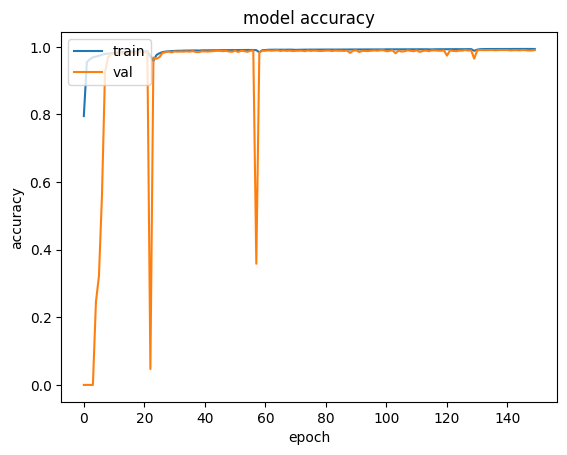

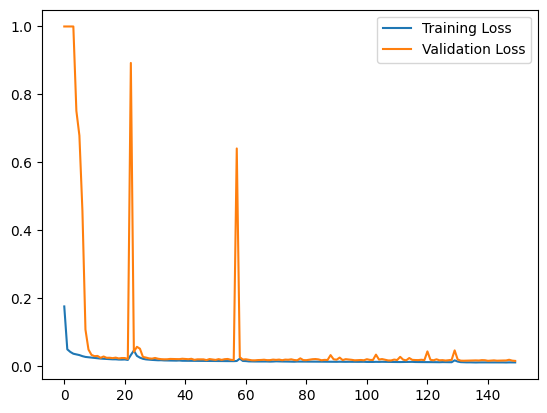

In [ ]:
#doesnt work on loaded model currently
import matplotlib.pyplot as plt
loss_name=""
if LOSS_FUNC_DICE:
  loss_name="dice_coefficient"
if LOSS_FUNC_TRAV:
  loss_name="tversky"
if USE_IOU:
  loss_name="iou"

plt.plot(history.history[loss_name])
plt.plot(history.history[f'val_{loss_name}'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0]  > 0.5
        display([image[0], mask[0], pred_mask])

1/1 [==============================] - 3s 3s/step


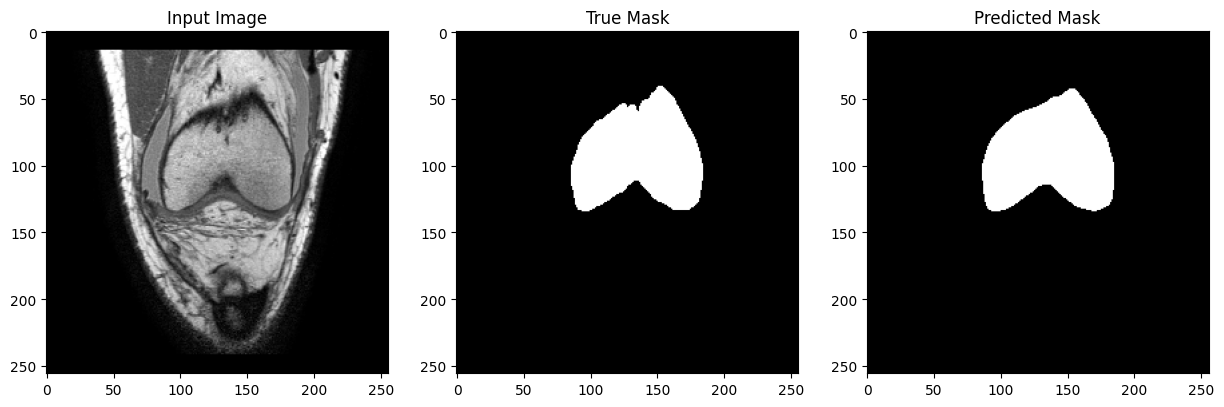

1/1 [==============================] - 0s 28ms/step


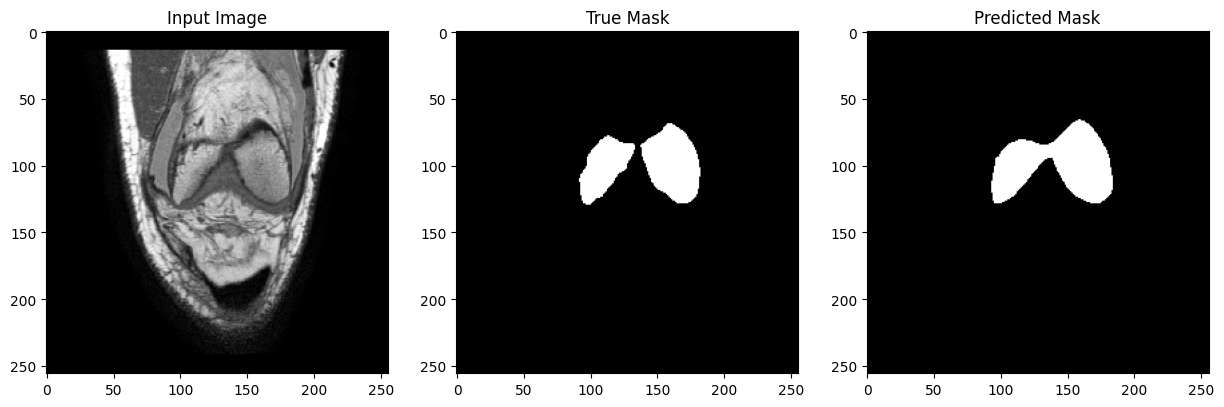

1/1 [==============================] - 0s 26ms/step


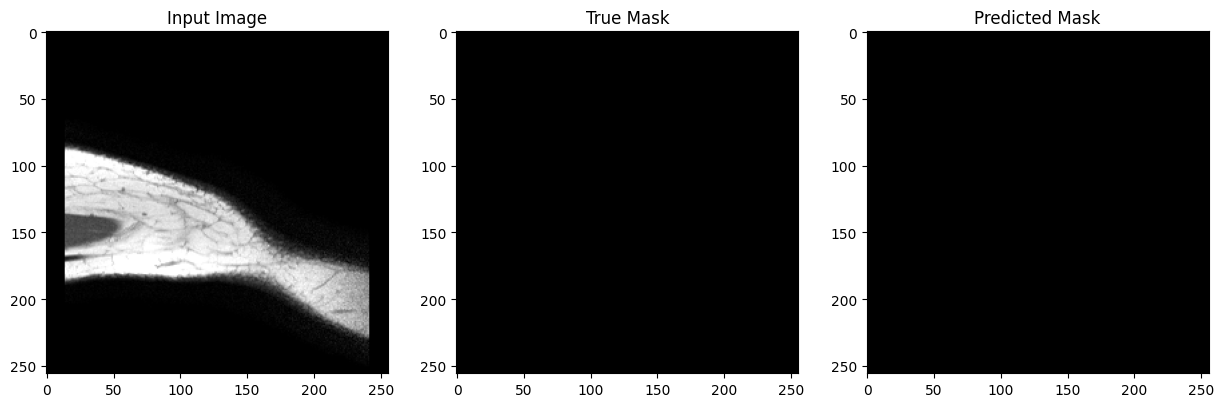

1/1 [==============================] - 0s 27ms/step


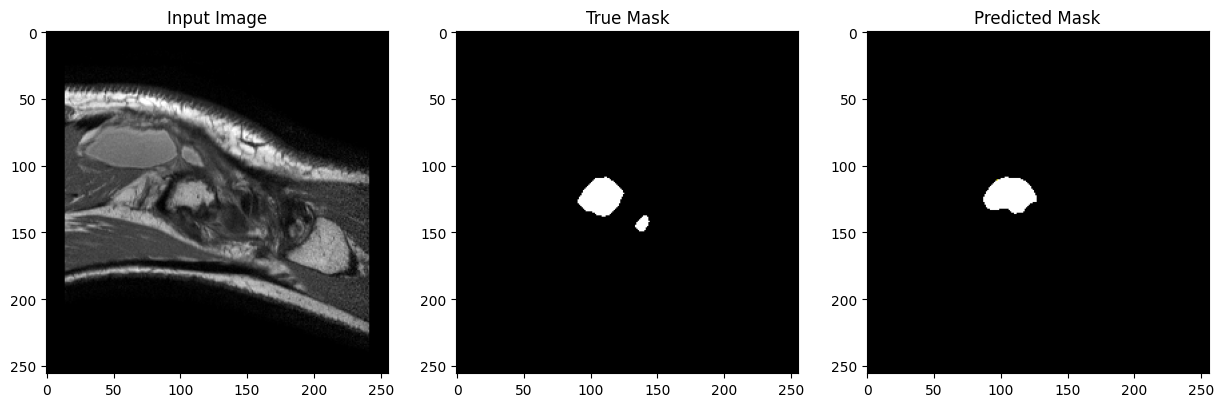

1/1 [==============================] - 0s 26ms/step


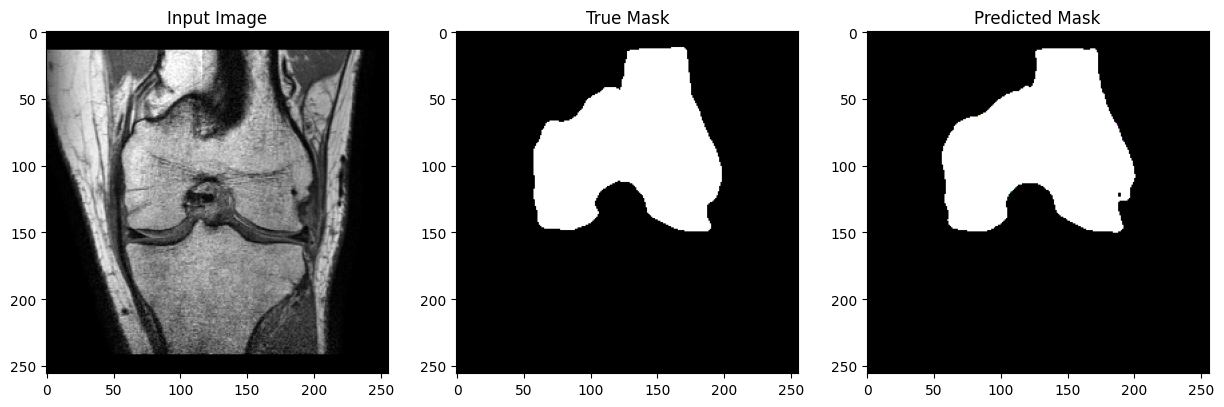

1/1 [==============================] - 0s 26ms/step


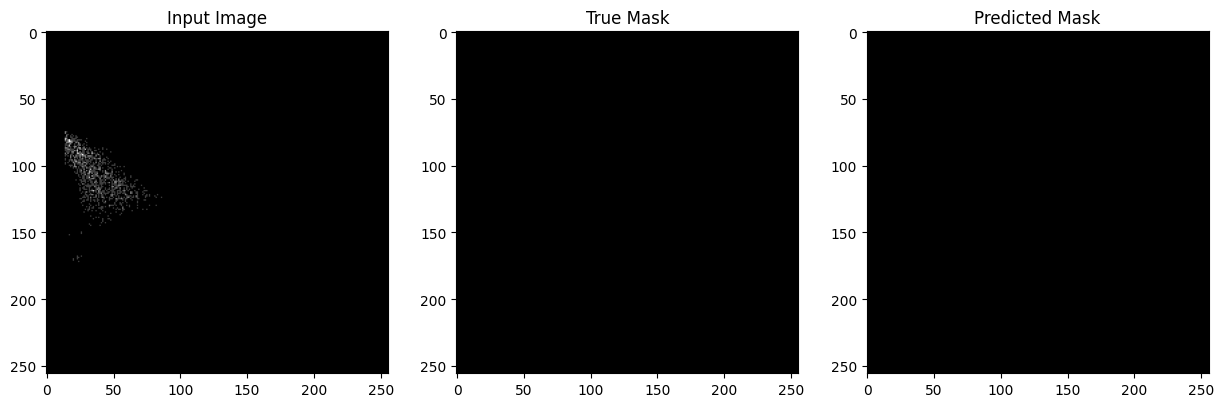

1/1 [==============================] - 0s 31ms/step


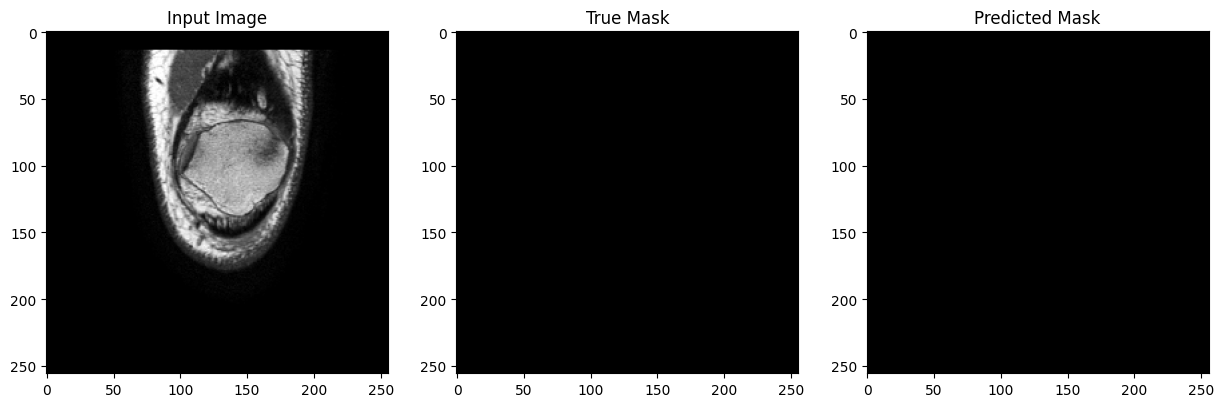

1/1 [==============================] - 0s 29ms/step


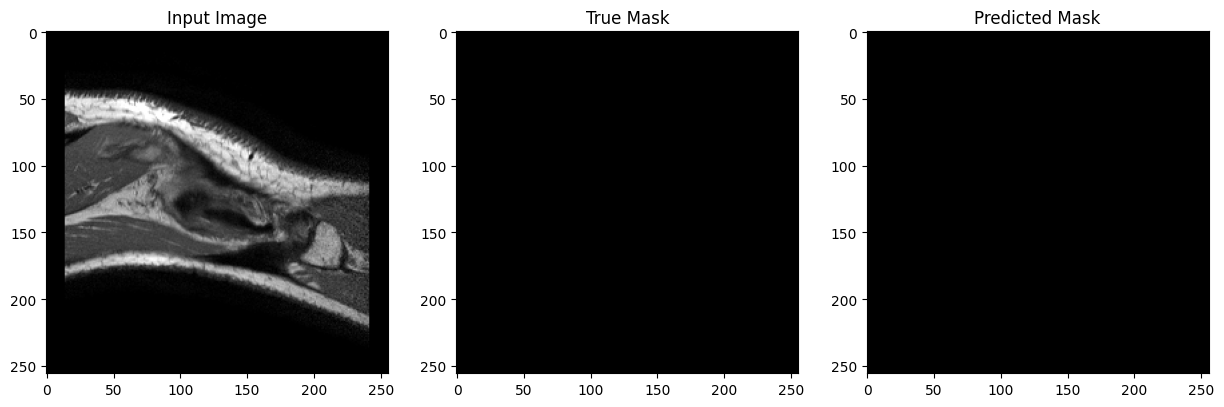

1/1 [==============================] - 0s 26ms/step


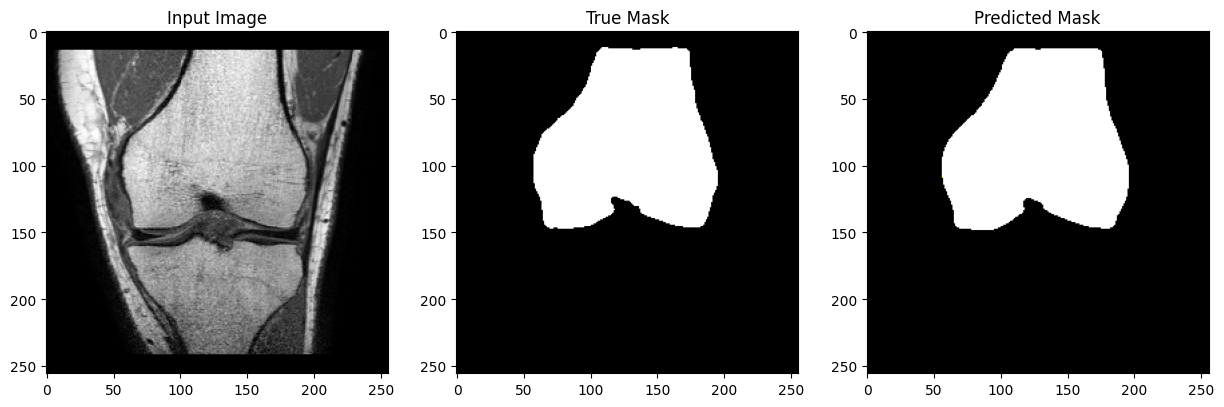

1/1 [==============================] - 0s 28ms/step


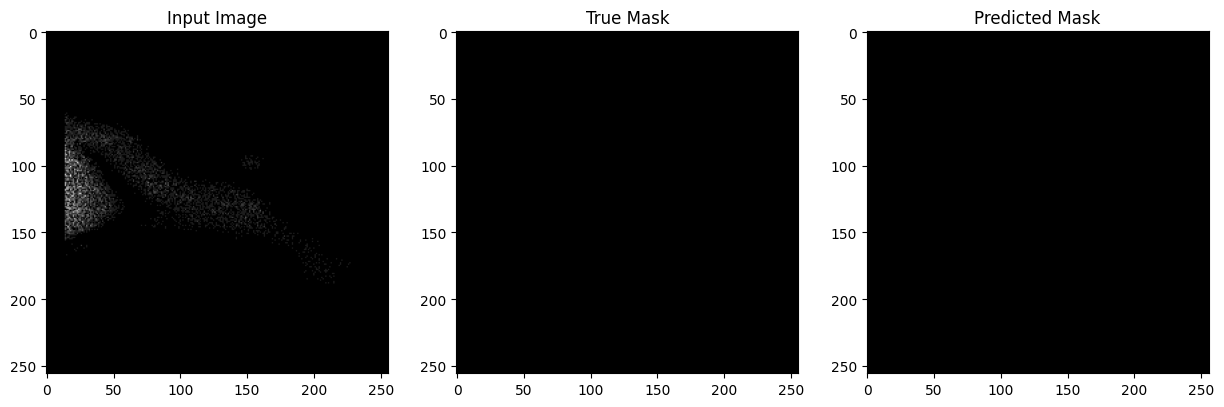

1/1 [==============================] - 0s 58ms/step


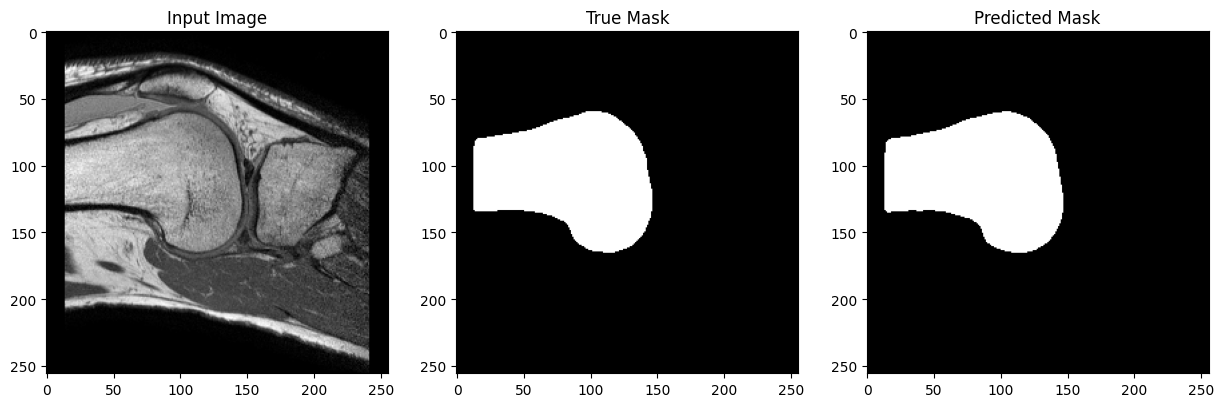

1/1 [==============================] - 0s 26ms/step


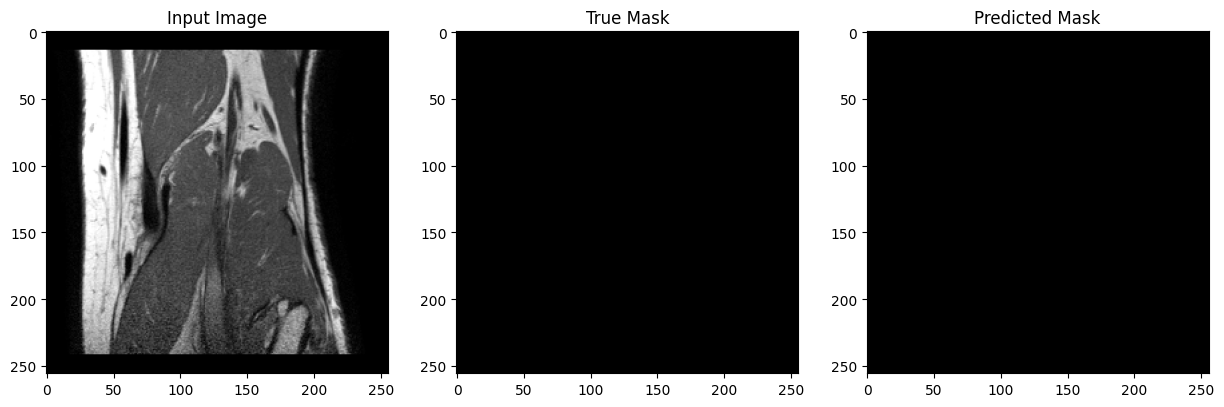

1/1 [==============================] - 0s 30ms/step


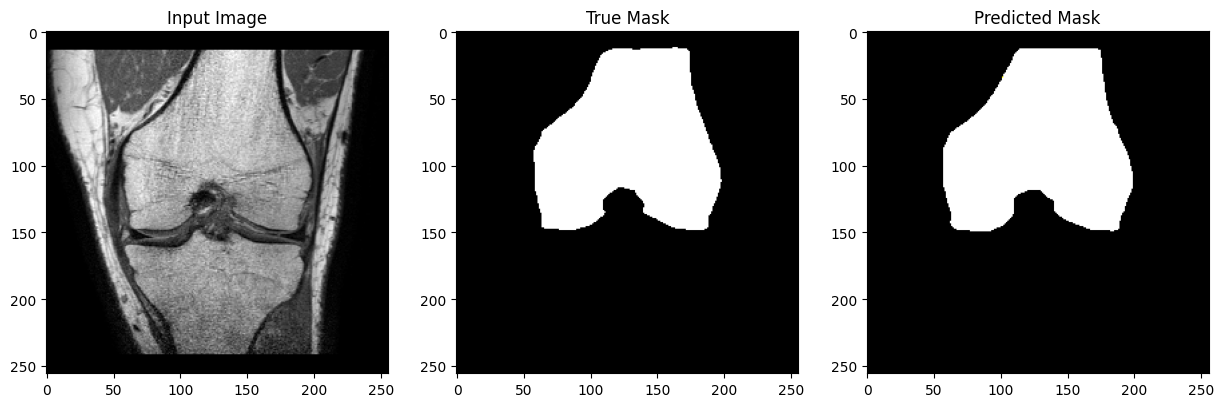

1/1 [==============================] - 0s 25ms/step


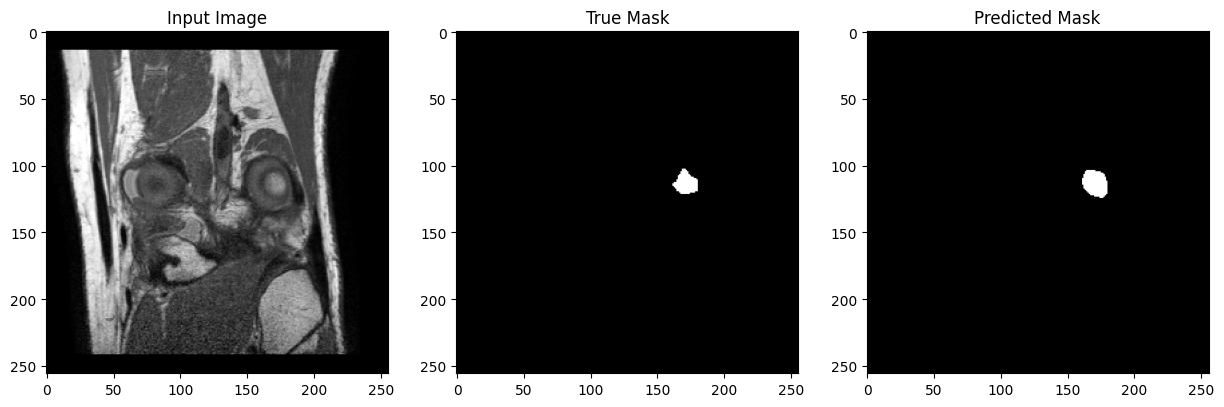

1/1 [==============================] - 0s 39ms/step


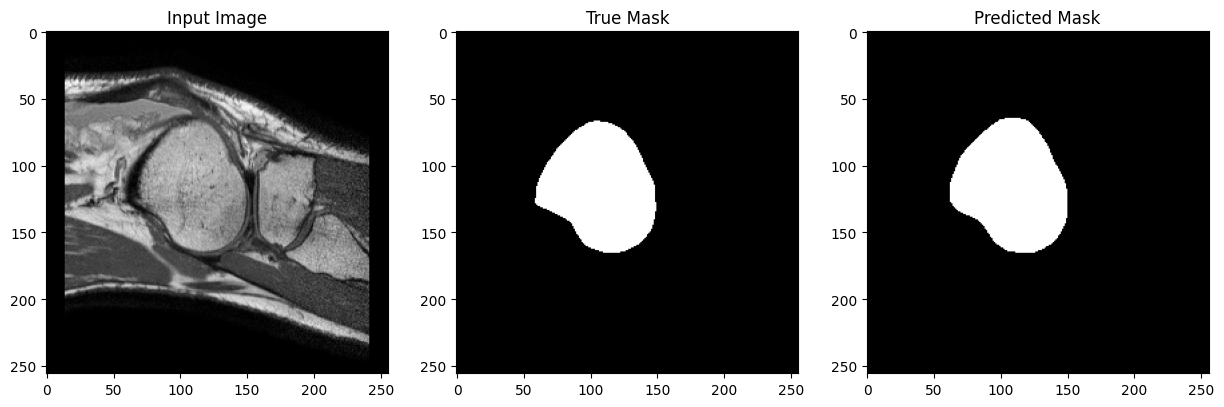

In [ ]:
show_prediction(validation_generator, 15)

# Predict entire volume, create 3d mesh

In [ ]:
!pip install scikit-image
!pip install numpy-stl
!pip install trimesh
!pip install pynrrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.1/681.1 kB 35.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
VOLUME_SLICE_X=True
VOLUME_SLICE_Y=True
VOLUME_SLICE_Z=True
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

# Normalize image
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape

    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))

    cnt = 0.0
    if VOLUME_SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = inImg[i,:,:]
            img = scaleImg(img, IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            if TRANSFER_LEARNING or CLASSIFIER:
              img = np.repeat(img, 3, axis=3)
            tmp = model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if VOLUME_SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            if TRANSFER_LEARNING or CLASSIFIER:
              img = np.repeat(img, 3, axis=3)
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if VOLUME_SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            if TRANSFER_LEARNING or CLASSIFIER:
              img = np.repeat(img, 3, axis=3)
            tmp = model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)

    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    return outImg

In [ ]:
import nibabel as nib
DPath = '/content/drive/My Drive/KneeProject/3D/ZA'
DImageInput = os.path.join(DPath, 'img/')
DMaskInput = os.path.join(DPath, 'mask/')
for index, filename in enumerate(sorted(glob.iglob(DImageInput+'*.nii'))):
    imgTargetNii = nib.load(filename)

imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())
predImg = predictVolume(imgTarget)



1/1 [==============================] - 0s 28ms/step


In [ ]:
from skimage import measure
import numpy as np
from stl import mesh
import shutil
import trimesh
from datetime import datetime
vertices, faces, _, _ = measure.marching_cubes(predImg)

knee_mesh=trimesh.Trimesh(vertices,faces)
knee_mesh=trimesh.smoothing.filter_laplacian(knee_mesh,0.5,20)
knee_mesh.export('knee-segmented.stl')

shutil.copy('knee-segmented.stl', f'/content/drive/My Drive/KneeProject/3D/Result/knee-segmented-{datetime.now()}.stl')


'/content/drive/My Drive/KneeProject/3D/Result/knee-segmented-2023-06-05 16:13:42.388540.stl'

In [ ]:
import numpy as np
import nrrd
flipped_predImg = np.flip(predImg, axis=1)
# Define the NRRD header (use appropriate metadata for your data)
header = {
    'type': 'uint8',
    'dimension': 3,
    'space': 'left-posterior-superior',
    'sizes': predImg.shape,
    'space directions': [[0, 1, 0], [0, 0, 1], [1, 0, 0]],
    'space origin': [0, 0, 0],
    'encoding': 'gzip',
    'endian': 'little'
}

# Save the 3D NumPy array as an NRRD file
nrrd.write('segmentation.seg.nrrd', flipped_predImg, header)
shutil.copy('segmentation.seg.nrrd', f'/content/drive/My Drive/KneeProject/3D/Result/segmentation{datetime.now()}.seg.nrrd')

'/content/drive/My Drive/KneeProject/3D/Result/segmentation2023-06-05 16:13:51.940246.seg.nrrd'